# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

# Import Libraries and Initialize `h2o` Cluster

In [2]:
import h2o
import os
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import shap
import pandas as pd

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch 

# init h2o
h2o.init(min_mem_size='30G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,09 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,1 month and 9 days
H2O cluster name:,H2O_from_python_navdeep_vcnglh
H2O cluster total nodes:,1
H2O cluster free memory:,28.14 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"locked, healthy"


# Import Processed HMDA Train and Test Datasets

In [3]:
train_path = os.sep.join(['..', 'data', 'output', 'hmda_train_processed.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'hmda_test_processed.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (160338, 24)
Test shape: (39662, 23)


In [5]:
train.head()

Unnamed: 0,high_priced,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
2.5493e+06,0,1,1,nan,nan,nan,nan,nan,nan,nan,1,0,1,0,1,False,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.0403074,0.854601
4.00076e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,1,0,5,False,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.0181326,-0.425131
1.54693e+06,0,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,5,False,-0.778227,0.228996,-4.09175,4.61086,-0.720941,-0.0323383,0.123326
5.45314e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3,False,-0.0746695,-1.15024,0.244394,-0.215304,0.358276,-0.0181326,-0.425131
4.94313e+06,0,1,1,0,0,1,0,0,1,0,nan,nan,0,1,4,False,-0.602338,0.55252,0.244394,-0.215304,-0.628437,-0.0382285,0.763191
1.23729e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3,False,-0.338504,0.372784,0.244394,-0.215304,-0.412593,-0.0247158,0.397554
682016,0,1,1,0,0,1,0,0,0,1,0,1,nan,nan,1,False,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.0209045,1.03742
19740,0,1,1,0,0,1,0,0,0,1,1,0,nan,nan,2,False,-0.734255,0.55252,0.244394,-0.215304,-0.720941,-0.0396144,0.488963
5.36388e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,0,1,5,False,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.0319161
1.94229e+06,0,1,0,0,0,1,0,0,0,1,nan,nan,0,1,4,False,1.33245,-0.261719,0.244394,-0.215304,1.19082,0.0757636,-1.15641


In [6]:
train.summary()

,Unnamed: 0,high_priced,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,enum,real,real,real,real,real,real,real
mins,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,,-1.26192360553821,-3.4792433327941232,-4.09174686250922,-0.21530422241413488,-1.0909583443261746,-0.09782313461197675,-2.527546647809547
mean,3319386.4112125635,0.09670196709451284,0.9603275580336539,0.928027042871933,0.0787575295739894,0.07867769794614994,0.8355541040714131,0.004434284055446694,0.0025763843530009433,0.12107167983057363,0.8789283201694263,0.6126165686353815,0.3873834313646186,0.21633871324342252,0.7836612867565775,3.003037333632701,,8.938396999015344e-17,-3.775663977769495e-17,1.3400948202787506e-16,-4.254269270726192e-18,-1.063567317681548e-18,0.0,-2.7510941284029374e-16
maxs,6504996.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,,51.50492551541175,202.75528359110467,0.24439439525512616,16.877348931294414,40.8443375990408,305.5429652264891,3.87111034635691
sigma,1952820.8522752034,0.295552434347859,0.1951890799460008,0.25844393424533546,0.2693609245488,0.2692360374620666,0.3706810494787445,0.06644285679708556,0.05069285202604093,0.3262117410182472,0.3262117410182472,0.48715526363003847,0.48715526363003847,0.4117503573990468,0.4117503573990468,1.41151976175012,,1.0000031184269407,1.0000031184269407,1.0000031184269407,1.0000031184269407,1.0000031184269405,1.000003118426941,1.0000031184269407
zeros,0,144833,6361,11540,126938,126949,22659,137179,137435,121184,16693,33523,53014,63801,17613,0,,0,0,0,0,0,0,0
missing,0,0,0,0,22548,22548,22548,22548,22548,22461,22461,73801,73801,78924,78924,0,0,0,0,0,0,0,0,0
0,2549300.0,0.0,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,1.0,0.0,1.0,False,-0.5143932429914191,0.3339223958668174,0.24439439525512616,-0.21530422241413488,-0.5359323686051412,-0.04030738198147695,0.8546006205355803
1,4000757.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,1.0,0.0,5.0,False,-0.11864187458429434,0.26872662571185846,0.24439439525512616,-0.21530422241413488,-0.22758460431567815,-0.018132633979356542,-0.4251307782977112
2,1546928.0,0.0,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,5.0,False,-0.7782274885961689,0.228995556370366,-4.09174686250922,4.610856668044749,-0.720941027178819,-0.03233833191821493,0.12332553548798514


In [7]:
test.head()

Unnamed: 0,high_priced,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
131497,0,1,1,0,1,0,0,0,1,0,1,0,nan,nan,False,-0.470421,0.345133,0.244394,-0.215304,-0.505098,-0.0080847,-2.52755
851117,0,1,1,0,1,0,0,0,0,1,1,0,nan,nan,False,0.321082,0.342439,-4.09175,3.20323,0.0807632,-0.0108565,-1.15641
835616,0,1,1,0,0,1,0,0,0,1,nan,nan,0,1,False,-0.118642,0.55252,0.244394,-0.215304,-0.289254,-0.0160538,1.03742
121491,0,0,1,0,0,1,0,0,0,1,1,0,1,0,False,-0.64631,-1.19197,0.244394,-0.215304,-0.320089,-0.02922,0.0319161
4.47964e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,0,1,False,0.277109,0.336837,0.244394,-0.215304,0.0499284,0.00057731,0.763191
843194,1,1,1,0,1,0,0,0,nan,nan,nan,nan,0,1,False,0.321082,0.444679,0.244394,-0.215304,0.0499284,-0.0351102,3.87111
6.37726e+06,0,1,1,0,0,1,0,0,0,1,0,1,nan,nan,False,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.0340707,1.58588
5.25537e+06,0,1,1,0,0,1,0,0,1,0,0,1,nan,nan,False,-0.690283,-0.182763,0.244394,-0.215304,-0.597602,-0.0247158,0.94601
4.59782e+06,0,1,1,0,1,0,0,0,0,1,1,0,nan,nan,False,0.716833,-0.682306,-4.09175,4.61086,0.913302,-0.0243693,0.306144
6.13819e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,1,0,False,0.145192,-0.246306,0.244394,-0.215304,0.142433,-0.0302594,1.03742


In [8]:
test.summary()

,Unnamed: 0,high_priced,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,enum,real,real,real,real,real,real,real
mins,4056.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,-1.26192360553821,-3.4586567959595325,-4.09174686250922,-0.21530422241413488,-1.029288791468282,-0.05278067773266968,-2.527546647809547
mean,3323235.642428521,0.09752407846301246,0.9601885936160557,0.9262014018455953,0.07671265111627497,0.08197782157249169,0.8342206665293996,0.004294496573227049,0.0027943642086066416,0.12101442886949366,0.8789855711305063,0.6133134578655611,0.3866865421344389,0.22066733067729083,0.7793326693227092,,0.004096505679623418,-0.00846253655870321,-0.010447651839036788,0.0055571501904296584,0.005967330951646153,0.010591915149438086,-0.007259301127656858
maxs,6504997.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,,19.05331330602753,37.75782848293456,0.24439439525512616,14.263178448962517,27.40037507602021,137.15347258538733,3.87111034635691
sigma,1954622.3871122967,0.29667381367158185,0.19551834219733183,0.26144614833636154,0.2661388804577039,0.27433496324350387,0.3718879052734942,0.06539250456663769,0.05278861339759911,0.3261488353928688,0.3261488353928688,0.487002164716498,0.487002164716498,0.4147069141947798,0.4147069141947798,,0.9853674098950168,0.6456480788175912,1.0198592403214601,0.9844019248509008,0.9922639123326747,1.2475615471305674,0.9950299052385418
zeros,0,35794,1579,2927,31389,31210,5636,33851,33902,29911,4118,8301,13166,15649,4431,,0,0,0,0,0,0,0
missing,0,0,0,0,5665,5665,5665,5665,5665,5633,5633,18195,18195,19582,19582,0,0,0,0,0,0,0,0
0,131497.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,nan,nan,False,-0.4704208687239607,0.3451325282916518,0.24439439525512616,-0.21530422241413488,-0.5050975921761949,-0.00808470129089574,-2.527546647809547
1,851117.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,nan,nan,False,0.32108186809028866,0.3424391847869839,-4.09174686250922,3.2032264083275748,0.08076315997378489,-0.01085654479116079,-1.1564058633453065
2,835616.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,0.0,1.0,False,-0.11864187458429434,0.5525199781510916,0.24439439525512616,-0.21530422241413488,-0.2892541571735708,-0.01605375135415776,1.037419391797479


# Setup Predictors, Response, and Fold Column for Modelling Purposes

In [23]:
# Inputs and output
X = ['term_360',
'conforming',
'debt_to_income_ratio_missing',
'loan_amount_std',
'loan_to_value_ratio_std',
'no_intro_rate_period_std',
'intro_rate_period_std',
'property_value_std',
'income_std',
'debt_to_income_ratio_std']
fold_column = 'cv_fold'
Y = 'high_priced'

# Convert outcome to categorical
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

In [25]:
# Distribution of outcome in train
train[Y].table()

high_priced,Count
0,144833
1,15505


In [26]:
# Distribution of outcome in test
test[Y].table()

high_priced,Count
0,35794
1,3868


In [27]:
# Function to get Shapley contributions
def get_shapley(model, train, X):
    # calculate SHAP values using function predict_contributions
    contributions = model.predict_contributions(train[X])
    print("First 5 rows of contributions:\n")
    print(contributions.head(5))
    # convert the H2O Frame to use with shap's visualization functions
    contributions_matrix = contributions.as_data_frame().as_matrix()
    # shap values are calculated for all features
    shap_values = contributions_matrix[:,0:len(X)]
    # expected values is the last returned column
    expected_value = contributions_matrix[:,len(X)-1].min()
    return shap_values, expected_value

# Create Pandas Frame for Correlation Calculation Purposes

In [28]:
train_pd_for_corr = train.as_data_frame()

In [29]:
# Calculate correlation
numeric_corr = pd.DataFrame(train_pd_for_corr[X + [Y]].corr()[Y]).iloc[:-1]
numeric_corr

,high_priced
term_360,0.052448
conforming,0.074543
debt_to_income_ratio_missing,0.008857
loan_amount_std,-0.123545
loan_to_value_ratio_std,0.111540
no_intro_rate_period_std,0.018108
intro_rate_period_std,-0.031716
property_value_std,-0.137319
income_std,-0.007911
debt_to_income_ratio_std,0.128645


In [30]:
# Filter to correlations > 0.1
numeric_corr = numeric_corr[numeric_corr['high_priced'].abs() > 0.1]
numeric_corr

,high_priced
loan_amount_std,-0.123545
loan_to_value_ratio_std,0.111540
property_value_std,-0.137319
debt_to_income_ratio_std,0.128645


# Make monotonicity constraints dictionary, which is based on heuristics known about the dataset:
## `debt_to_income_ratio` will be positively constrained to the outcome
## `loan_to_value_ratio` will be positively constrained to the outcome
## `income` will be negatively constrained to the outcome
## `term_360` will be negatively constrained to the outcome

In [31]:
mono_constraints = dict()
mono_constraints['debt_to_income_ratio_std'] = 1
mono_constraints['loan_to_value_ratio_std'] = 1
mono_constraints['income_std'] = -1
mono_constraints['term_360'] = -1
mono_constraints

{'debt_to_income_ratio_std': 1,
 'loan_to_value_ratio_std': 1,
 'income_std': -1,
 'term_360': -1}

# Build Default GBM with Monotonic Constraints

In [32]:
mgbm_default = H2OGradientBoostingEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED,
               categorical_encoding="one_hot_explicit")
mgbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


# Model Summary

In [33]:
mgbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1575925687897_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,17381.0,5.0,5.0,5.0,9.0,32.0,22.98




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07746923148219471
RMSE: 0.2783329507661547
LogLoss: 0.260311833499752
Mean Per-Class Error: 0.2536735673014884
AUC: 0.8079388964460537
pr_auc: 0.27083899487029695
Gini: 0.6158777928921073

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16050013682564504: 


,,0,1,Error,Rate
0,0,113716.0,31117.0,0.2148,(31117.0/144833.0)
1,1,5588.0,9917.0,0.3604,(5588.0/15505.0)
2,Total,119304.0,41034.0,0.2289,(36705.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.160500,0.350802,185.0
1,max f2,0.100428,0.519115,241.0
2,max f0point5,0.235457,0.297843,117.0
3,max accuracy,0.629338,0.903529,12.0
4,max precision,0.755401,1.000000,0.0
5,max recall,0.006322,1.000000,396.0
6,max specificity,0.755401,1.000000,0.0
7,max absolute_mcc,0.128072,0.298557,215.0
8,max min_per_class_accuracy,0.138872,0.730628,205.0
9,max mean_per_class_accuracy,0.091369,0.746326,250.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.69 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011033,0.366827,4.185524,4.185524,0.404748,0.438297,0.404748,0.438297,0.046179,0.046179,318.552443,318.552443
1,,2,0.021592,0.330887,3.591576,3.895070,0.347312,0.344095,0.376661,0.392230,0.037923,0.084102,259.157599,289.506957
2,,3,0.030716,0.308132,3.209048,3.691283,0.310321,0.321051,0.356954,0.371086,0.029281,0.113383,220.904804,269.128287
3,,4,0.040228,0.293384,3.282012,3.594517,0.317377,0.303693,0.347597,0.355152,0.031216,0.144599,228.201234,259.451736
4,,5,0.050163,0.268439,2.577148,3.393017,0.249215,0.278971,0.328111,0.340064,0.025605,0.170203,157.714837,239.301682
5,,6,0.100681,0.238399,2.700163,3.045367,0.261111,0.252269,0.294493,0.296011,0.136408,0.306611,170.016339,204.536689
6,,7,0.150445,0.214653,2.279723,2.792110,0.220454,0.225940,0.270002,0.272833,0.113447,0.420058,127.972292,179.210957
7,,8,0.200027,0.181454,2.211294,2.648137,0.213836,0.199033,0.256080,0.254540,0.109642,0.529700,121.129398,164.813713
8,,9,0.301276,0.143597,1.816723,2.368727,0.175681,0.163362,0.229061,0.223898,0.183941,0.713641,81.672282,136.872712
9,,10,0.400011,0.096532,1.318842,2.109583,0.127535,0.119017,0.204001,0.198010,0.130216,0.843857,31.884167,110.958284




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07786691732767274
RMSE: 0.2790464429582874
LogLoss: 0.26184112441054336
Mean Per-Class Error: 0.2551517057866107
AUC: 0.8047385674202855
pr_auc: 0.26197778676858546
Gini: 0.609477134840571

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16144778019404407: 


,,0,1,Error,Rate
0,0,113586.0,31247.0,0.2157,(31247.0/144833.0)
1,1,5678.0,9827.0,0.3662,(5678.0/15505.0)
2,Total,119264.0,41074.0,0.2303,(36925.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.161448,0.347373,203.0
1,max f2,0.087112,0.516665,279.0
2,max f0point5,0.232498,0.293769,139.0
3,max accuracy,0.611152,0.903348,14.0
4,max precision,0.862930,1.000000,0.0
5,max recall,0.005448,1.000000,399.0
6,max specificity,0.862930,1.000000,0.0
7,max absolute_mcc,0.122144,0.294907,242.0
8,max min_per_class_accuracy,0.136550,0.729700,228.0
9,max mean_per_class_accuracy,0.087112,0.744848,279.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.69 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010166,0.375019,3.895341,3.895341,0.376687,0.453095,0.376687,0.453095,0.039600,0.039600,289.534079,289.534079
1,,2,0.020008,0.332917,3.669828,3.784412,0.354880,0.351174,0.365960,0.402960,0.036117,0.075718,266.982808,278.441216
2,,3,0.030149,0.312497,3.090868,3.551126,0.298893,0.324982,0.343401,0.376731,0.031345,0.107062,209.086772,255.112642
3,,4,0.040065,0.291343,3.167353,3.456139,0.306289,0.303840,0.334215,0.358690,0.031409,0.138471,216.735344,245.613902
4,,5,0.050269,0.270604,2.787533,3.320427,0.269560,0.279100,0.321092,0.342535,0.028442,0.166914,178.753277,232.042689
5,,6,0.100001,0.238947,2.646863,2.985451,0.255957,0.254313,0.288699,0.298661,0.131635,0.298549,164.686301,198.545131
6,,7,0.150070,0.212385,2.361129,2.777154,0.228326,0.225365,0.268556,0.274206,0.118220,0.416769,136.112942,177.715374
7,,8,0.200034,0.183508,2.146694,2.619681,0.207590,0.197471,0.253328,0.255040,0.107256,0.524025,114.669433,161.968140
8,,9,0.300197,0.143312,1.824816,2.354467,0.176463,0.163053,0.227682,0.224347,0.182780,0.706804,82.481565,135.446743
9,,10,0.400192,0.097110,1.333185,2.099282,0.128922,0.119111,0.203005,0.198052,0.133312,0.840116,33.318487,109.928208




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7704801,0.014431337,0.7920445,0.75499684,0.76842666,0.7608514,0.77608097
1,auc,0.8048742,0.00280107,0.80185527,0.80827004,0.803526,0.8074152,0.80330443
2,err,0.22951993,0.014431337,0.20795546,0.24500315,0.23157336,0.23914862,0.22391905
3,err_count,7360.0,460.4655,6650.0,7796.0,7421.0,7719.0,7214.0
4,f0point5,0.27453804,0.007236497,0.28003556,0.2797435,0.26934677,0.26436567,0.2791987
5,f1,0.34848258,0.00741789,0.34662998,0.35972404,0.34414494,0.34053823,0.35137564
6,f2,0.4774484,0.017465457,0.45477983,0.5037494,0.4764585,0.4783736,0.47388077
7,lift_top_group,3.920367,0.25636455,3.5213163,3.8844738,4.192557,4.088432,3.9150565
8,logloss,0.26185217,0.004189886,0.26224622,0.2665671,0.2588397,0.2565283,0.26507956
9,max_per_class_error,0.36508095,0.042322766,0.42578125,0.3128334,0.35932872,0.34483892,0.38262242



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-09 13:20:21,15.676 sec,0.0,0.295552,0.317775,0.500000,0.000000,1.000000,0.903298
1,,2019-12-09 13:20:21,16.054 sec,1.0,0.293001,0.309425,0.774476,0.227195,3.199757,0.254943
2,,2019-12-09 13:20:22,16.358 sec,2.0,0.291030,0.303305,0.775249,0.239186,3.942622,0.246118
3,,2019-12-09 13:20:22,16.397 sec,3.0,0.289515,0.298726,0.776227,0.239274,3.500892,0.226210
4,,2019-12-09 13:20:22,16.423 sec,4.0,0.288318,0.295140,0.774524,0.239349,4.016215,0.226235
5,,2019-12-09 13:20:22,16.449 sec,5.0,0.287294,0.292073,0.775406,0.242985,4.064141,0.228187
6,,2019-12-09 13:20:22,16.478 sec,6.0,0.286586,0.289781,0.776410,0.243305,4.061651,0.220671
7,,2019-12-09 13:20:22,16.506 sec,7.0,0.285554,0.286630,0.780791,0.248294,4.061651,0.227894
8,,2019-12-09 13:20:22,16.535 sec,8.0,0.284760,0.283998,0.784599,0.249709,4.044661,0.235434
9,,2019-12-09 13:20:22,16.572 sec,9.0,0.284024,0.281708,0.786704,0.251037,4.042575,0.231636



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,3650.476562,1.000000e+00,4.375255e-01
1,property_value_std,2176.975830,5.963539e-01,2.609200e-01
2,debt_to_income_ratio_std,1193.050049,3.268204e-01,1.429922e-01
3,intro_rate_period_std,602.766052,1.651198e-01,7.224413e-02
4,loan_amount_std,525.585449,1.439772e-01,6.299370e-02
5,no_intro_rate_period_std,149.259399,4.088765e-02,1.788939e-02
6,conforming,33.390831,9.146979e-03,4.002036e-03
7,income_std,7.539486,2.065343e-03,9.036401e-04
8,debt_to_income_ratio_missing.False,4.415467,1.209559e-03,5.292129e-04
9,term_360,0.001692,4.635131e-07,2.027988e-07


In [34]:
# Get the AUC on the test set for MGBM
perf_mgbm_default = mgbm_default.model_performance(test)
print(perf_mgbm_default.auc())

0.808905130264245


In [35]:
# Get the AUC on 5 fold CV for MGBM
perf_cv_mgbm_default = mgbm_default.model_performance(xval=True)
print(perf_cv_mgbm_default.auc())

0.8047385674202855


# Build Default GBM with NO Monotonic Constraints

In [36]:
gbm_default = H2OGradientBoostingEstimator(
               seed=SEED,
               categorical_encoding="one_hot_explicit")
gbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


# Model Summary

In [37]:
gbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1575925687897_418


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,21720.0,5.0,5.0,5.0,22.0,32.0,29.9




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0757316619042703
RMSE: 0.27519386240298005
LogLoss: 0.2526668544940987
Mean Per-Class Error: 0.23803431310394685
AUC: 0.8241574690166849
pr_auc: 0.30286940310761046
Gini: 0.6483149380333697

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1748981761202983: 


,,0,1,Error,Rate
0,0,113444.0,31389.0,0.2167,(31389.0/144833.0)
1,1,4936.0,10569.0,0.3183,(4936.0/15505.0)
2,Total,118380.0,41958.0,0.2266,(36325.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.174898,0.367854,200.0
1,max f2,0.106860,0.538358,261.0
2,max f0point5,0.257875,0.320982,120.0
3,max accuracy,0.411694,0.904402,44.0
4,max precision,0.796284,1.000000,0.0
5,max recall,0.005666,1.000000,398.0
6,max specificity,0.796284,1.000000,0.0
7,max absolute_mcc,0.133277,0.321932,240.0
8,max min_per_class_accuracy,0.155944,0.747482,219.0
9,max mean_per_class_accuracy,0.106860,0.761966,261.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010291,0.366205,5.201862,5.201862,0.503030,0.423953,0.503030,0.423953,0.053531,0.053531,420.186216,420.186216
1,,2,0.020089,0.337407,3.686180,4.462608,0.356461,0.349156,0.431543,0.387471,0.036117,0.089649,268.617996,346.260828
2,,3,0.030323,0.311893,3.459620,4.124084,0.334552,0.323703,0.398807,0.365949,0.035408,0.125056,245.962044,312.408441
3,,4,0.040059,0.291681,3.332190,3.931628,0.322229,0.301962,0.380196,0.350398,0.032441,0.157498,233.219013,293.162809
4,,5,0.050007,0.280969,3.170391,3.780197,0.306583,0.285037,0.365553,0.337396,0.031538,0.189036,217.039127,278.019722
5,,6,0.100020,0.252807,2.773862,3.276998,0.268238,0.264928,0.316892,0.301159,0.138729,0.327765,177.386224,227.699835
6,,7,0.150002,0.223107,2.405256,2.986526,0.232593,0.238116,0.288803,0.280153,0.120219,0.447985,140.525575,198.652622
7,,8,0.200327,0.199909,2.256859,2.803223,0.218243,0.210968,0.271077,0.262773,0.113576,0.561561,125.685851,180.322333
8,,9,0.300328,0.155734,1.870986,2.492813,0.180928,0.178507,0.241060,0.234714,0.187101,0.748662,87.098601,149.281312
9,,10,0.399999,0.084520,1.228813,2.177853,0.118829,0.122466,0.210603,0.206745,0.122477,0.871138,22.881274,117.785265




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.0763104038609322
RMSE: 0.27624337794946724
LogLoss: 0.254824328692756
Mean Per-Class Error: 0.2411510506536242
AUC: 0.8198539766244762
pr_auc: 0.2862189867678687
Gini: 0.6397079532489525

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1728701422882463: 


,,0,1,Error,Rate
0,0,112706.0,32127.0,0.2218,(32127.0/144833.0)
1,1,4919.0,10586.0,0.3173,(4919.0/15505.0)
2,Total,117625.0,42713.0,0.231,(37046.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.172870,0.363668,212.0
1,max f2,0.108866,0.534668,269.0
2,max f0point5,0.257389,0.310773,130.0
3,max accuracy,0.451089,0.903622,38.0
4,max precision,0.869474,1.000000,0.0
5,max recall,0.005437,1.000000,399.0
6,max specificity,0.869474,1.000000,0.0
7,max absolute_mcc,0.126929,0.318723,252.0
8,max min_per_class_accuracy,0.154636,0.744230,228.0
9,max mean_per_class_accuracy,0.089810,0.758849,285.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010029,0.368916,4.617459,4.617459,0.446517,0.428848,0.446517,0.428848,0.046308,0.046308,361.745946,361.745946
1,,2,0.020020,0.334800,3.679400,4.149307,0.355805,0.350178,0.401246,0.389586,0.036762,0.083070,267.940027,314.930655
2,,3,0.030030,0.312203,3.537219,3.945278,0.342056,0.323211,0.381516,0.367461,0.035408,0.118478,253.721941,294.527751
3,,4,0.040321,0.292185,3.171256,3.747731,0.306667,0.301728,0.362413,0.350685,0.032635,0.151113,217.125572,274.773134
4,,5,0.050026,0.280927,2.924205,3.587975,0.282776,0.285381,0.346964,0.338016,0.028378,0.179490,192.420473,258.797478
5,,6,0.100020,0.251331,2.749099,3.168668,0.265843,0.265267,0.306416,0.301653,0.137440,0.316930,174.909933,216.866783
6,,7,0.150077,0.222941,2.457063,2.931318,0.237603,0.237342,0.283464,0.280203,0.122993,0.439923,145.706264,193.131824
7,,8,0.200002,0.200541,2.261984,2.764235,0.218738,0.211146,0.267307,0.262965,0.112931,0.552854,126.198386,176.423511
8,,9,0.300016,0.155401,1.883650,2.470682,0.182153,0.178919,0.238920,0.234947,0.188391,0.741245,88.364996,147.068232
9,,10,0.400036,0.085962,1.256118,2.167008,0.121469,0.121000,0.209554,0.206457,0.125637,0.866882,25.611822,116.700816




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7788916,0.022123443,0.79507786,0.80109996,0.7799413,0.7446169,0.77372193
1,auc,0.8200793,0.0018740107,0.81823957,0.8218998,0.81825435,0.822078,0.819925
2,err,0.2211084,0.022123443,0.20492214,0.19890006,0.22005866,0.2553831,0.22627805
3,err_count,7093.4,748.045,6553.0,6329.0,7052.0,8243.0,7290.0
4,f0point5,0.28908145,0.013466386,0.29325423,0.3072256,0.28294584,0.27073926,0.29124236
5,f1,0.3650672,0.008101144,0.36434183,0.37565354,0.3589091,0.35596532,0.37046632
6,f2,0.4966489,0.016836906,0.4809219,0.4832978,0.49062982,0.5194983,0.50889677
7,lift_top_group,4.653895,0.15403096,4.6264467,4.558055,4.9188175,4.631808,4.534347
8,logloss,0.25483617,0.004168726,0.25488704,0.25988072,0.2522701,0.24943149,0.25771156
9,max_per_class_error,0.34395748,0.05855545,0.38867188,0.40257296,0.35044423,0.2558235,0.3222749



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-09 13:20:52,13.272 sec,0.0,0.295552,0.317775,0.500000,0.000000,1.000000,0.903298
1,,2019-12-09 13:20:52,13.304 sec,1.0,0.292387,0.307527,0.798066,0.261304,4.197561,0.253939
2,,2019-12-09 13:20:52,13.328 sec,2.0,0.289790,0.299591,0.802684,0.267325,4.296634,0.272474
3,,2019-12-09 13:20:52,13.355 sec,3.0,0.287696,0.293356,0.805310,0.269337,4.301683,0.217509
4,,2019-12-09 13:20:52,13.379 sec,4.0,0.285985,0.288267,0.806769,0.270388,4.167028,0.216786
5,,2019-12-09 13:20:52,13.403 sec,5.0,0.284534,0.283930,0.808244,0.271697,4.294578,0.215158
6,,2019-12-09 13:20:52,13.426 sec,6.0,0.283368,0.280415,0.808974,0.273015,4.278063,0.233288
7,,2019-12-09 13:20:52,13.452 sec,7.0,0.282369,0.277301,0.809773,0.274218,4.431879,0.234056
8,,2019-12-09 13:20:52,13.479 sec,8.0,0.281528,0.274647,0.810421,0.275448,4.452931,0.230083
9,,2019-12-09 13:20:52,13.511 sec,9.0,0.280854,0.272468,0.810525,0.275984,4.463115,0.231461



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,4938.643066,1.000000,0.523122
1,property_value_std,1754.421265,0.355244,0.185836
2,debt_to_income_ratio_std,1225.825439,0.248211,0.129845
3,intro_rate_period_std,635.243591,0.128627,0.067288
4,loan_amount_std,521.774658,0.105651,0.055269
5,no_intro_rate_period_std,156.612869,0.031712,0.016589
6,income_std,119.916946,0.024281,0.012702
7,term_360,47.980827,0.009715,0.005082
8,conforming,33.125870,0.006707,0.003509
9,debt_to_income_ratio_missing.False,7.173559,0.001453,0.000760


In [38]:
# Get the AUC on the test set for the default GBM
perf_gbm_default = gbm_default.model_performance(test)
print(perf_gbm_default.auc())

0.8237209254218628


In [39]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_gbm_default = gbm_default.model_performance(xval=True)
print(perf_cv_gbm_default.auc())

0.8198539766244762


# Variable Importance of MGBM and GBM

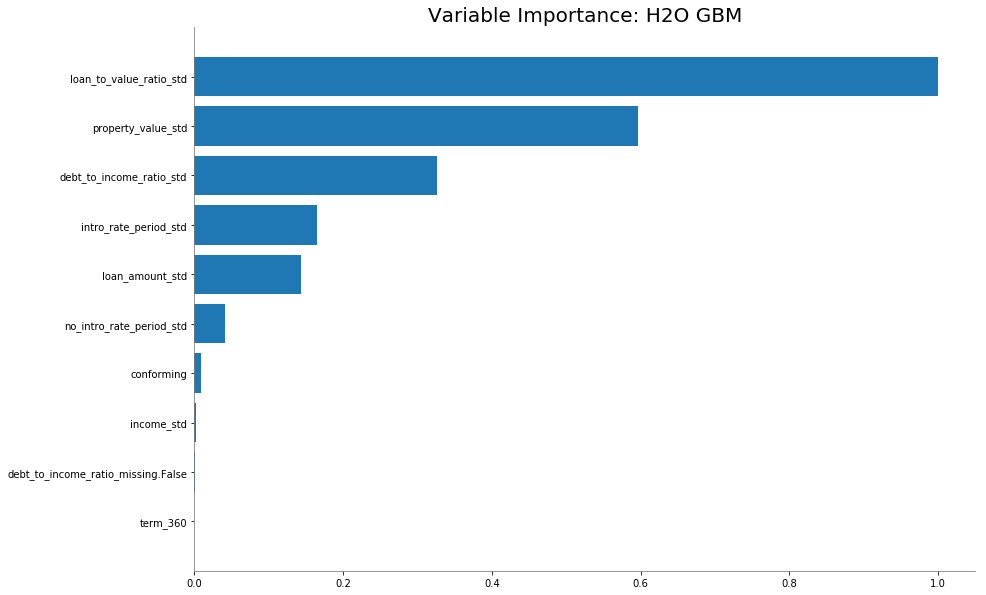

In [40]:
# MGBM var importance
mgbm_default.varimp_plot()

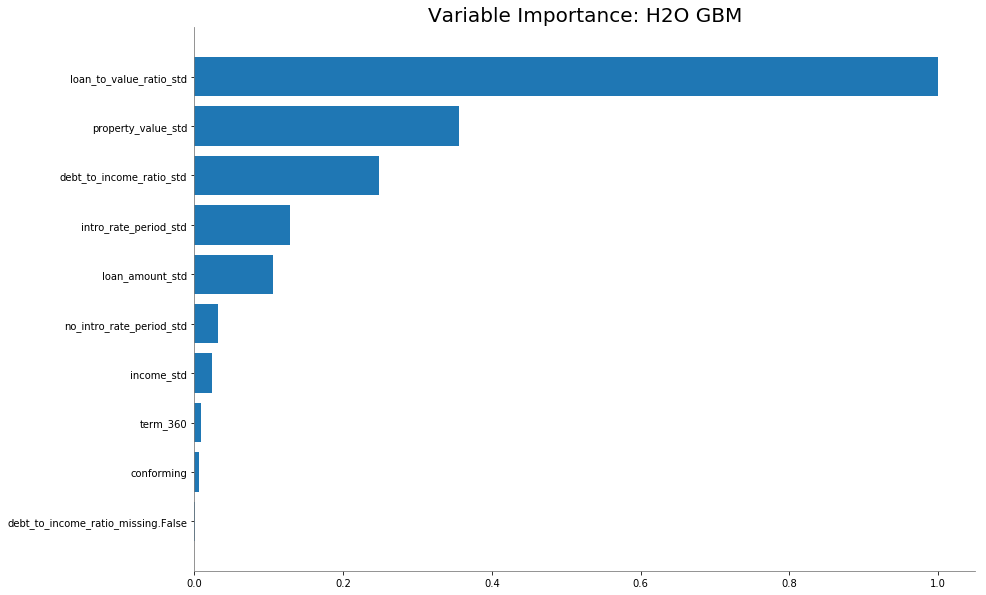

In [41]:
# GBM var importance
gbm_default.varimp_plot()

# Shapley Importance for MGBM and GBM

## Shapley for MGBM

In [42]:
shap_values_mgbm_default, expected_value_mgbm_default = get_shapley(mgbm_default, train, X)

First 5 rows of contributions:



term_360,conforming,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,debt_to_income_ratio_missing.False,debt_to_income_ratio_missing.True,debt_to_income_ratio_missing.missing(NA),BiasTerm
-4.57106e-06,0.00735352,0.0514138,0.842012,-0.00580597,-0.00170303,0.553635,0.0124719,0.267141,-0.000184935,0,0,-2.87949
-1.50614e-06,0.00768744,-0.073352,0.573904,-0.0085259,0.00141006,-0.104249,-0.00768904,-0.290046,-0.000237618,0,0,-2.87949
-4.57106e-06,0.00822359,0.370754,0.596289,-0.0673389,-0.615974,0.283736,-0.000276035,0.0216484,-0.000126609,0,0,-2.87949
-1.50614e-06,0.0116721,-0.0421028,-1.15109,-0.0262746,-0.0309957,-0.411278,-0.0237093,-0.1714,-0.000212137,0,0,-2.87949
-4.57106e-06,0.00469299,0.137133,1.05481,-0.00406382,-0.000802108,0.341723,0.0127726,0.252466,-0.000191413,0,0,-2.87949


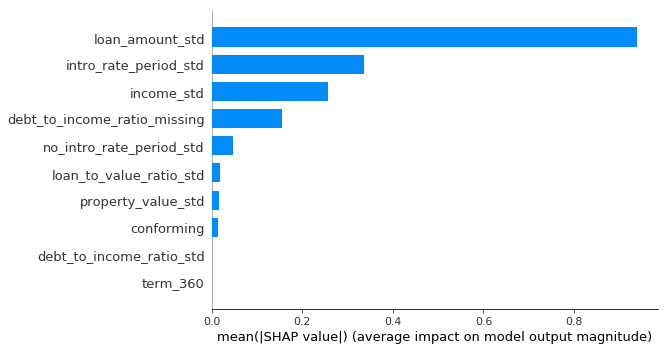

In [43]:
shap.summary_plot(shap_values_mgbm_default, X, plot_type="bar")

## Shapley for GBM

In [44]:
shap_values_gbm_default, expected_value_gbm_default = get_shapley(gbm_default, train, X)

First 5 rows of contributions:



term_360,conforming,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,debt_to_income_ratio_missing.False,debt_to_income_ratio_missing.True,debt_to_income_ratio_missing.missing(NA),BiasTerm
0.0119963,0.00246609,0.068955,1.05257,-0.0164529,0.00692202,0.508051,-0.0513176,0.231107,-0.0001993,0,0,-3.00977
0.0203195,0.00350931,0.0244885,0.604385,-0.0219534,0.00749184,-0.360197,0.00489432,-0.369034,-0.00031517,0,0,-3.00977
0.0118981,0.0041544,0.127661,0.689605,-0.321384,-0.415854,0.602444,0.0187778,-0.0260705,-0.000213344,0,0,-3.00977
0.0136289,0.00478551,-0.0133384,-1.14775,-0.118928,-0.00935209,-0.507958,0.00600047,-0.191414,-0.000893107,0,0,-3.00977
0.0154476,0.00246609,0.102547,1.14454,-0.0114345,0.0115538,0.431013,-0.0103283,0.232346,-0.000154641,0,0,-3.00977


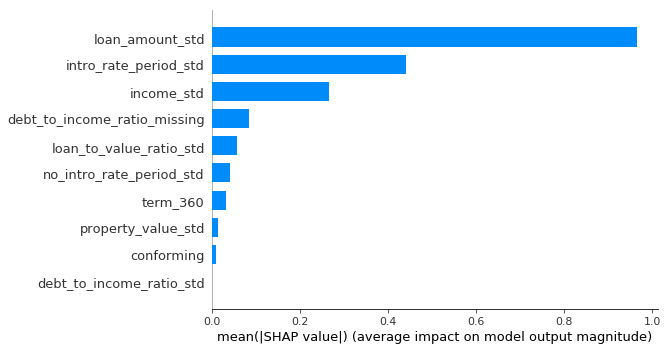

In [45]:
shap.summary_plot(shap_values_gbm_default, X, plot_type="bar")

In [1]:
# Build Default XGBoost with Monotonic Constraints

In [46]:
mxgb_default = H2OXGBoostEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED)
mxgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


# Model Summary

In [47]:
mxgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1575925687897_931


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07762546454250034
RMSE: 0.27861346798476977
LogLoss: 0.2600707538323361
Mean Per-Class Error: 0.2576287073263952
AUC: 0.8062379074746303
pr_auc: 0.26888416210329724
Gini: 0.6124758149492606

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1690960709424414: 


,,0,1,Error,Rate
0,0,114157.0,30676.0,0.2118,(30676.0/144833.0)
1,1,5772.0,9733.0,0.3723,(5772.0/15505.0)
2,Total,119929.0,40409.0,0.2273,(36448.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.169096,0.348142,163.0
1,max f2,0.104239,0.514039,237.0
2,max f0point5,0.233018,0.293056,105.0
3,max accuracy,0.474129,0.903523,31.0
4,max precision,0.875909,1.000000,0.0
5,max recall,0.001659,1.000000,395.0
6,max specificity,0.875909,1.000000,0.0
7,max absolute_mcc,0.126256,0.292397,210.0
8,max min_per_class_accuracy,0.145369,0.726540,190.0
9,max mean_per_class_accuracy,0.097395,0.742371,245.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.74 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011064,0.356938,4.226191,4.226191,0.408681,0.411933,0.408681,0.411933,0.046759,0.046759,322.619063,322.619063
1,,2,0.020588,0.331251,3.690814,3.978532,0.356909,0.337290,0.384732,0.377404,0.035150,0.081909,269.081398,297.853230
2,,3,0.032257,0.300754,3.089603,3.656957,0.298771,0.316449,0.353635,0.355353,0.036053,0.117962,208.960324,265.695723
3,,4,0.040022,0.273410,3.156305,3.559823,0.305221,0.286516,0.344242,0.341998,0.024508,0.142470,215.630481,255.982270
4,,5,0.050300,0.261326,2.698211,3.383761,0.260922,0.265141,0.327216,0.326293,0.027733,0.170203,169.821119,238.376123
5,,6,0.100288,0.240890,2.623002,3.004564,0.253649,0.250942,0.290547,0.288734,0.131119,0.301322,162.300153,200.456415
6,,7,0.151199,0.213675,2.414559,2.805900,0.233493,0.223936,0.271336,0.266916,0.122928,0.424250,141.455883,180.590007
7,,8,0.200002,0.188826,2.111821,2.636536,0.204217,0.202337,0.254958,0.251158,0.103064,0.527314,111.182108,163.653596
8,,9,0.300191,0.151126,1.772218,2.348071,0.171377,0.169119,0.227063,0.223777,0.177556,0.704869,77.221826,134.807092
9,,10,0.400092,0.109434,1.300217,2.086426,0.125734,0.128625,0.201761,0.200018,0.129894,0.834763,30.021708,108.642598




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.0782797307863066
RMSE: 0.2797851511183297
LogLoss: 0.26391161672737234
Mean Per-Class Error: 0.2640070213704946
AUC: 0.798732101317958
pr_auc: 0.25492089548757935
Gini: 0.597464202635916

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16327585172085535: 


,,0,1,Error,Rate
0,0,112578.0,32255.0,0.2227,(32255.0/144833.0)
1,1,5584.0,9921.0,0.3601,(5584.0/15505.0)
2,Total,118162.0,42176.0,0.236,(37839.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.163276,0.343995,189.0
1,max f2,0.106512,0.507641,252.0
2,max f0point5,0.215648,0.285605,140.0
3,max accuracy,0.952242,0.903304,0.0
4,max precision,0.952242,1.000000,0.0
5,max recall,0.000433,1.000000,399.0
6,max specificity,0.952242,1.000000,0.0
7,max absolute_mcc,0.138112,0.287951,216.0
8,max min_per_class_accuracy,0.143558,0.725637,211.0
9,max mean_per_class_accuracy,0.099263,0.735993,260.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.69 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010353,0.354732,3.806254,3.806254,0.368072,0.418577,0.368072,0.418577,0.039407,0.039407,280.625441,280.625441
1,,2,0.020045,0.324773,3.393781,3.606820,0.328185,0.338285,0.348787,0.379755,0.032893,0.072299,239.378131,260.681969
2,,3,0.030286,0.304131,3.331557,3.513743,0.322168,0.316421,0.339786,0.358339,0.034118,0.106417,233.155671,251.374271
3,,4,0.040109,0.273867,2.764179,3.330169,0.267302,0.285482,0.322034,0.340496,0.027153,0.133570,176.417942,233.016905
4,,5,0.050200,0.263173,2.543720,3.172078,0.245983,0.267200,0.306746,0.325762,0.025669,0.159239,154.371966,217.207797
5,,6,0.100051,0.239285,2.661271,2.917566,0.257350,0.250949,0.282134,0.288486,0.132667,0.291906,166.127142,191.756627
6,,7,0.150008,0.214789,2.389674,2.741763,0.231086,0.225620,0.265134,0.267550,0.119381,0.411287,138.967365,174.176301
7,,8,0.200121,0.189296,2.168596,2.598235,0.209708,0.202499,0.251254,0.251260,0.108675,0.519961,116.859632,159.823465
8,,9,0.300472,0.148716,1.782209,2.325701,0.172343,0.168564,0.224900,0.223642,0.178846,0.698807,78.220853,132.570086
9,,10,0.400049,0.107141,1.267533,2.062310,0.122573,0.128001,0.199429,0.199836,0.126217,0.825024,26.753334,106.230965




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.77324414,0.019544147,0.76724625,0.8054997,0.75335455,0.76583946,0.77428067
1,auc,0.79898,0.0034089838,0.7950255,0.8023207,0.7981366,0.8027014,0.7967159
2,err,0.22675589,0.019544147,0.23275377,0.19450031,0.24664545,0.23416054,0.22571935
3,err_count,7273.2,648.7185,7443.0,6189.0,7904.0,7558.0,7272.0
4,f0point5,0.27366853,0.013980155,0.26927122,0.29628605,0.26027754,0.26578072,0.27672705
5,f1,0.3450911,0.0075461566,0.3432454,0.35618433,0.33680147,0.34060374,0.34862056
6,f2,0.46836054,0.012446837,0.47325903,0.4464379,0.47706205,0.47406256,0.47098118
7,lift_top_group,3.808692,0.2287151,3.6756728,3.5257099,4.10965,3.9507008,3.7817264
8,logloss,0.26392356,0.0048803934,0.26530334,0.26852083,0.26026046,0.25746855,0.26806465
9,max_per_class_error,0.3825464,0.047772843,0.36686197,0.4628177,0.3395854,0.3583169,0.38515007



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-09 13:21:58,23.359 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.903298
1,,2019-12-09 13:21:59,23.780 sec,1.0,0.405190,0.517787,0.785280,0.246994,3.532712,0.237024
2,,2019-12-09 13:21:59,23.837 sec,2.0,0.350527,0.423514,0.787615,0.249774,4.024719,0.237186
3,,2019-12-09 13:21:59,23.884 sec,3.0,0.319052,0.366969,0.788270,0.249770,4.032035,0.224102
4,,2019-12-09 13:21:59,23.933 sec,4.0,0.301347,0.331397,0.789771,0.250441,4.029504,0.224095
5,,2019-12-09 13:21:59,23.989 sec,5.0,0.291633,0.308583,0.791773,0.251509,4.067138,0.227557
6,,2019-12-09 13:21:59,24.082 sec,6.0,0.286340,0.293630,0.792451,0.251672,4.064393,0.218769
7,,2019-12-09 13:21:59,24.137 sec,7.0,0.283464,0.283752,0.793673,0.252398,4.069869,0.227307
8,,2019-12-09 13:21:59,24.212 sec,8.0,0.281931,0.277220,0.794130,0.252655,4.086227,0.218308
9,,2019-12-09 13:21:59,24.290 sec,9.0,0.281083,0.272918,0.794707,0.253553,4.071328,0.226303



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,17366.339844,1.000000,0.548268
1,property_value_std,4905.364258,0.282464,0.154866
2,loan_amount_std,3695.568604,0.212801,0.116672
3,debt_to_income_ratio_std,2890.878418,0.166464,0.091267
4,intro_rate_period_std,1570.096191,0.090410,0.049569
5,no_intro_rate_period_std,926.157043,0.053331,0.029239
6,income_std,215.108414,0.012387,0.006791
7,conforming,89.246017,0.005139,0.002818
8,debt_to_income_ratio_missing.False,14.767391,0.000850,0.000466
9,term_360,1.370327,0.000079,0.000043


In [48]:
# Get the AUC on the test set for MXGB
perf_mxgb_default = mxgb_default.model_performance(test)
print(perf_mxgb_default.auc())

0.8031621930708982


In [49]:
# Get the AUC on 5 fold CV for the default MXGB
perf_cv_mxgb_default = mxgb_default.model_performance(xval=True)
print(perf_cv_mxgb_default.auc())

0.798732101317958


# Build Default XGBoost with NO Monotonic Constraints

In [50]:
xgb_default = H2OXGBoostEstimator(
               seed=SEED)
xgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


# Model Summary

In [51]:
xgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1575925687897_1298


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07346298335980485
RMSE: 0.2710405566696705
LogLoss: 0.2421490326043258
Mean Per-Class Error: 0.22331836139590344
AUC: 0.8436379645315262
pr_auc: 0.34572862742360894
Gini: 0.6872759290630523

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18837254450994756: 


,,0,1,Error,Rate
0,0,119013.0,25820.0,0.1783,(25820.0/144833.0)
1,1,5469.0,10036.0,0.3527,(5469.0/15505.0)
2,Total,124482.0,35856.0,0.1951,(31289.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.188373,0.390802,207.0
1,max f2,0.116665,0.555551,266.0
2,max f0point5,0.286709,0.347332,129.0
3,max accuracy,0.407835,0.905805,71.0
4,max precision,0.976949,1.000000,0.0
5,max recall,0.002968,1.000000,392.0
6,max specificity,0.976949,1.000000,0.0
7,max absolute_mcc,0.146853,0.342875,241.0
8,max min_per_class_accuracy,0.154572,0.760658,235.0
9,max mean_per_class_accuracy,0.100494,0.776682,280.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010029,0.398797,6.283089,6.283089,0.607587,0.504357,0.607587,0.504357,0.063012,0.063012,528.308899,528.308899
1,,2,0.020101,0.355230,4.354127,5.316513,0.421053,0.375510,0.514117,0.439794,0.043857,0.106869,335.412685,431.651317
2,,3,0.030030,0.332043,3.585591,4.744212,0.346734,0.344439,0.458775,0.408267,0.035601,0.142470,258.559064,374.421231
3,,4,0.040015,0.312552,3.352283,4.396881,0.324172,0.321365,0.425187,0.386582,0.033473,0.175943,235.228333,339.688090
4,,5,0.050069,0.298603,3.406388,4.197993,0.329404,0.305312,0.405954,0.370263,0.034247,0.210190,240.638848,319.799279
5,,6,0.100001,0.260014,2.839075,3.519466,0.274544,0.277976,0.340339,0.324183,0.141761,0.351951,183.907453,251.946593
6,,7,0.150083,0.229153,2.601360,3.213100,0.251557,0.243968,0.310713,0.297416,0.130281,0.482232,160.136035,221.310008
7,,8,0.200021,0.201311,2.332451,2.993233,0.225553,0.215210,0.289452,0.276892,0.116479,0.598710,133.245143,199.323311
8,,9,0.300047,0.147321,1.807975,2.598106,0.174835,0.174280,0.251242,0.242684,0.180845,0.779555,80.797529,159.810611
9,,10,0.400005,0.090062,1.179475,2.243603,0.114058,0.118626,0.216961,0.211683,0.117897,0.897452,17.947474,124.360310




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.07591257519788946
RMSE: 0.27552236787217377
LogLoss: 0.25259123052519633
Mean Per-Class Error: 0.23773409899953646
AUC: 0.8238216494036668
pr_auc: 0.29450270841790577
Gini: 0.6476432988073335

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18051382249051875: 


,,0,1,Error,Rate
0,0,116129.0,28704.0,0.1982,(28704.0/144833.0)
1,1,5490.0,10015.0,0.3541,(5490.0/15505.0)
2,Total,121619.0,38719.0,0.2133,(34194.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.180514,0.369394,214.0
1,max f2,0.108680,0.538509,275.0
2,max f0point5,0.267184,0.312990,142.0
3,max accuracy,0.647777,0.903847,24.0
4,max precision,0.984118,1.000000,0.0
5,max recall,0.000463,1.000000,399.0
6,max specificity,0.984118,1.000000,0.0
7,max absolute_mcc,0.124495,0.321406,262.0
8,max min_per_class_accuracy,0.148132,0.747049,242.0
9,max mean_per_class_accuracy,0.096345,0.762266,284.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.65 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.407604,4.848174,4.848174,0.468828,0.503449,0.468828,0.503449,0.048500,0.048500,384.817366,384.817366
1,,2,0.020001,0.357424,3.760969,4.304741,0.363693,0.379752,0.416277,0.441620,0.037601,0.086101,276.096874,330.474071
2,,3,0.030005,0.331201,3.275096,3.961454,0.316708,0.343188,0.383080,0.408802,0.032764,0.118865,227.509604,296.145448
3,,4,0.040003,0.314332,3.173922,3.764633,0.306925,0.322009,0.364047,0.387111,0.031732,0.150597,217.392216,276.463279
4,,5,0.050001,0.300628,3.122314,3.636201,0.301934,0.307055,0.351628,0.371104,0.031216,0.181812,212.231367,263.620102
5,,6,0.100020,0.256860,2.783832,3.209937,0.269202,0.277189,0.310407,0.324137,0.139245,0.321058,178.383163,220.993660
6,,7,0.150008,0.227910,2.514624,2.978233,0.243169,0.242128,0.288001,0.296809,0.125701,0.446759,151.462370,197.823309
7,,8,0.200002,0.200990,2.293711,2.807124,0.221806,0.214426,0.271454,0.276216,0.114673,0.561432,129.371122,180.712397
8,,9,0.300004,0.146988,1.865826,2.493358,0.180429,0.174819,0.241113,0.242417,0.186585,0.748017,86.582645,149.335813
9,,10,0.399999,0.089371,1.240952,2.180271,0.120002,0.118056,0.210837,0.211328,0.124089,0.872106,24.095195,118.027123




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7828028,0.014824913,0.7890112,0.7881207,0.7686139,0.8015615,0.766707
1,auc,0.8239214,0.0030833608,0.82043314,0.8278595,0.82220495,0.8263717,0.8227375
2,err,0.21719715,0.014824913,0.2109888,0.21187933,0.23138613,0.19843851,0.23329298
3,err_count,6965.0,478.78857,6747.0,6742.0,7415.0,6405.0,7516.0
4,f0point5,0.29361784,0.009722157,0.2951657,0.30725196,0.27999464,0.294061,0.29161587
5,f1,0.37064147,0.009523416,0.37079176,0.38429224,0.35983768,0.36388916,0.37439653
6,f2,0.50296193,0.017143423,0.4985205,0.5128955,0.50338167,0.4772076,0.5228044
7,lift_top_group,4.8096123,0.29514456,4.506554,4.9452076,4.927531,4.500409,5.1683593
8,logloss,0.25260153,0.004006559,0.253692,0.25633025,0.25011146,0.24695344,0.2559206
9,max_per_class_error,0.33882216,0.040979568,0.3528646,0.339818,0.3142481,0.39776462,0.28941548



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-09 13:22:27,23.165 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.903298
1,,2019-12-09 13:22:27,23.297 sec,1.0,0.404391,0.516382,0.809869,0.280465,4.499264,0.250932
2,,2019-12-09 13:22:27,23.359 sec,2.0,0.348688,0.420389,0.814731,0.288584,4.714393,0.205566
3,,2019-12-09 13:22:27,23.420 sec,3.0,0.316417,0.362362,0.817815,0.292598,4.594236,0.198543
4,,2019-12-09 13:22:27,23.479 sec,4.0,0.298103,0.325531,0.819057,0.295706,4.663219,0.231636
5,,2019-12-09 13:22:27,23.560 sec,5.0,0.287869,0.301381,0.820475,0.297663,4.988231,0.201524
6,,2019-12-09 13:22:27,23.626 sec,6.0,0.282221,0.285339,0.821568,0.299208,5.036385,0.202154
7,,2019-12-09 13:22:27,23.699 sec,7.0,0.279034,0.274409,0.822936,0.300948,5.023653,0.220659
8,,2019-12-09 13:22:27,23.774 sec,8.0,0.277181,0.266922,0.823907,0.303666,5.151814,0.212077
9,,2019-12-09 13:22:28,23.855 sec,9.0,0.276026,0.261623,0.825572,0.306710,5.303103,0.203994



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,21562.857422,1.000000,0.517523
1,property_value_std,5853.233398,0.271450,0.140482
2,debt_to_income_ratio_std,3998.149902,0.185418,0.095958
3,loan_amount_std,3346.707275,0.155207,0.080323
4,income_std,2775.886230,0.128735,0.066623
5,intro_rate_period_std,2675.397705,0.124074,0.064211
6,no_intro_rate_period_std,1030.331787,0.047783,0.024729
7,term_360,269.373260,0.012492,0.006465
8,conforming,116.245148,0.005391,0.002790
9,debt_to_income_ratio_missing.False,37.325474,0.001731,0.000896


In [52]:
# Get the AUC on the test set for the default GBM
perf_xgb_default = xgb_default.model_performance(test)
print(perf_xgb_default.auc())

0.8280878975747641


In [53]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_xgb_default = xgb_default.model_performance(xval=True)
print(perf_cv_xgb_default.auc())

0.8238216494036668


# Variable Importance of MXGB and XGB

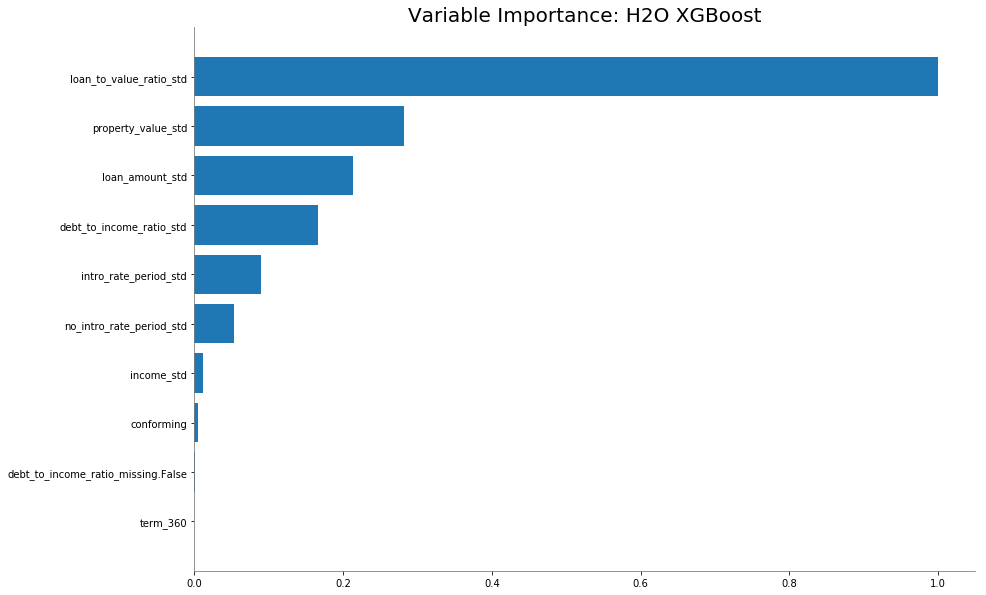

In [54]:
# MXGB var importance
mxgb_default.varimp_plot()

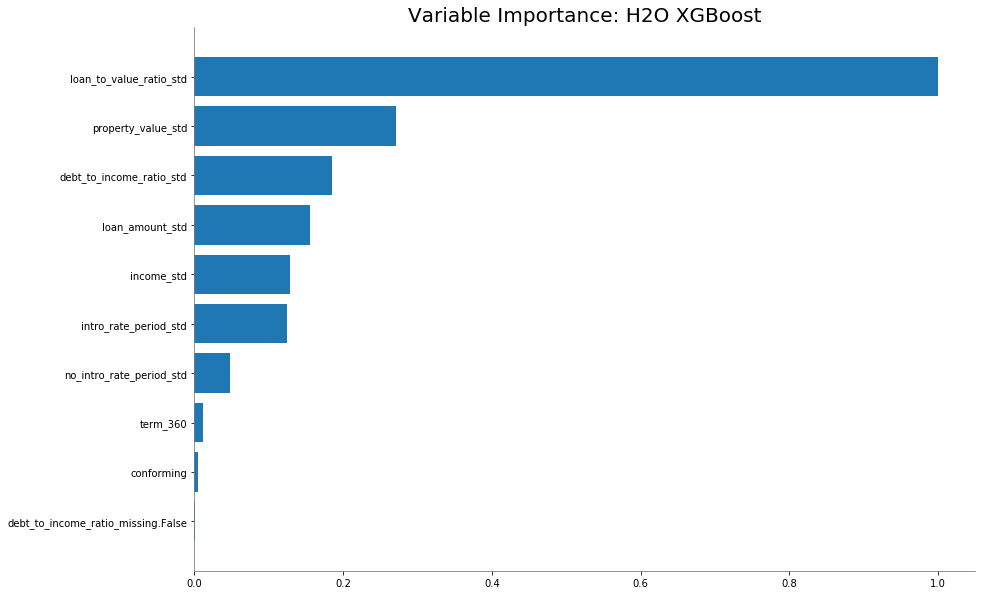

In [55]:
# XGB var importance
xgb_default.varimp_plot()

# Shapley Importance for MXGB and XGB

## Shapey for MXGB

In [56]:
shap_values_mxgb_default, expected_value_mxgb_default = get_shapley(mxgb_default, train, X)

First 5 rows of contributions:



debt_to_income_ratio_missing.False,debt_to_income_ratio_missing.True,debt_to_income_ratio_missing.missing(NA),term_360,conforming,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,BiasTerm
-2.98902e-05,0,0,-2.06251e-05,-0.00374499,-0.780964,0.133854,-0.0361677,-0.0434363,-0.123355,0.0101909,-0.216221,0
-0.000281135,0,0,-1.97926e-05,-0.00100632,-0.614443,-0.414059,-0.0256902,-0.0618107,-0.428796,-0.0089271,-0.937681,0
-8.52665e-05,0,0,-1.77338e-05,-0.00730571,-0.465455,-0.00296585,-0.282846,-0.572081,-0.128206,-0.0700573,-0.352035,0
-0.00103777,0,0,-3.13982e-05,-0.00894576,-1.82511,-2.01086,-0.143934,-0.264119,-0.676105,-0.123941,-0.850855,0
-0.000186064,0,0,-2.06251e-05,-0.00368282,-0.728184,0.196378,-0.0484225,-0.0394591,-0.230825,-0.0197131,-0.23308,0


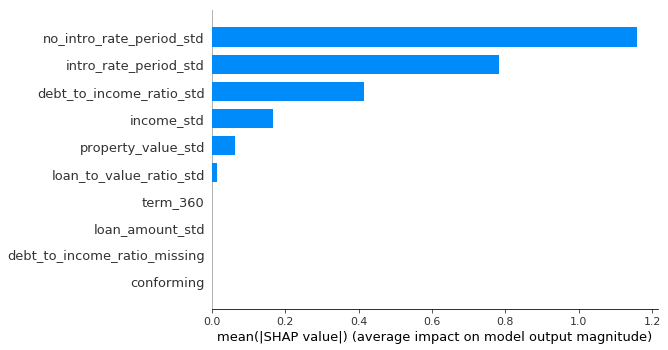

In [57]:
shap.summary_plot(shap_values_mxgb_default, X, plot_type="bar")

## Shapley for XGB

In [58]:
shap_values_xgb_default, expected_value_xgb_default = get_shapley(xgb_default, train, X)

First 5 rows of contributions:



debt_to_income_ratio_missing.False,debt_to_income_ratio_missing.True,debt_to_income_ratio_missing.missing(NA),term_360,conforming,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,BiasTerm
-4.35354e-05,0,0,0.000756169,-0.000440774,-0.363497,0.0929364,-0.0271633,-0.0102367,-0.355676,-0.558442,-0.344734,0
-0.00026653,0,0,0.0138007,0.00216415,-0.282659,-0.776825,-0.0346796,-0.0789705,-0.983352,-0.516417,-0.919282,0
-0.00011001,0,0,-0.00522695,0.00174915,-0.237179,-0.283227,-0.312884,-0.818544,-0.22195,-0.408122,-0.572551,0
-0.000589084,0,0,0.00655149,0.00419639,-0.519215,-1.63001,-0.206296,-0.113357,-1.18688,-0.226466,-0.796942,0
0.000121103,0,0,0.000828575,-0.000766235,-0.327656,-0.0205416,-0.0259274,-0.0134669,-0.236151,-0.291408,-0.179639,0


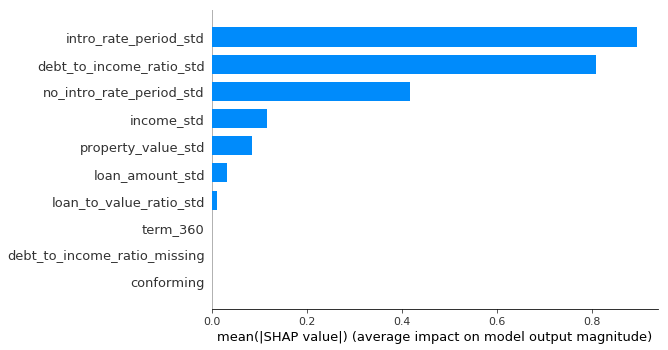

In [59]:
shap.summary_plot(shap_values_xgb_default, X, plot_type="bar")

# MGBM Grid Search (Constrained)

In [60]:
# GBM hyperparameters
hyper_params = {'learn_rate': [i * 0.01 for i in range(1, 11)],
                'max_depth': list(range(2, 11)),
                'sample_rate': [i * 0.1 for i in range(5, 11)],
                'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 36, 'seed': 1}

In [61]:
# Train and validate a random grid of GBMs
mgbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='mgbm_grid2',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
mgbm_grid2.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [62]:
# Get the grid results, sorted by validation AUC
mgbm_gridperf2 = mgbm_grid2.get_grid(sort_by='auc', decreasing=True)

In [63]:
print(mgbm_gridperf2)

          col_sample_rate learn_rate max_depth         sample_rate  \
0                     1.0       0.09        10                 0.9   
1                     0.8       0.09        10  0.7000000000000001   
2      0.7000000000000001       0.09        10                 0.5   
3      0.7000000000000001       0.08         9  0.6000000000000001   
4                     0.5        0.1         8  0.7000000000000001   
5                     0.9       0.08         6                 0.8   
6                     1.0       0.09         5                 0.5   
7                     0.9       0.06         6                 0.9   
8                     0.8       0.05        10  0.6000000000000001   
9     0.30000000000000004        0.1         6  0.7000000000000001   
10                    0.4       0.08         5                 0.8   
11    0.30000000000000004       0.08         6                 0.8   
12                    0.4       0.07         5                 0.5   
13     0.70000000000

In [64]:
# Grab the top GBM model, chosen by validation AUC
best_mgbm2 = mgbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_mgbm_perf2 = best_mgbm2.model_performance(test)

best_mgbm_perf2.auc()

0.8139763217062082

# Shapley Importance

In [65]:
shap_values_mgbm, expected_value_mgbm = get_shapley(best_mgbm2, train, X)

First 5 rows of contributions:



term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,BiasTerm
-0.00018562,0.00525494,-0.00119815,0.107912,0.887901,-0.00580012,-0.00468927,0.527515,0.0166724,0.272783,-2.91142
-0.000157597,0.00815592,-0.0021666,-0.146934,0.536647,-0.0180488,-0.00987545,-0.0619093,-0.00628095,-0.29549,-2.91142
-0.00274492,0.00705713,-0.00344599,0.388739,0.620492,-0.14514,-0.943326,0.0448351,-0.0277831,0.018798,-2.91142
-0.000380784,0.012291,-0.00452263,-0.0809743,-1.31932,-0.0377705,-0.0840968,-0.308984,-0.000403701,-0.190623,-2.91142
-0.000354039,0.00488184,-0.00119556,0.354748,1.07438,-0.00380643,-0.00236983,0.153142,0.0352928,0.256853,-2.91142


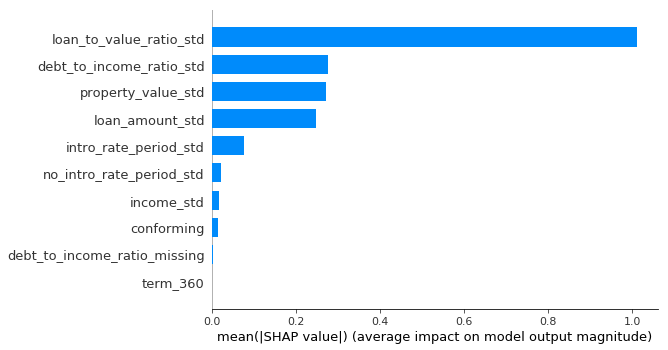

In [66]:
shap.summary_plot(shap_values_mgbm, X, plot_type="bar")

In [67]:
# Save the model
model_path = h2o.save_model(model=best_mgbm2, path="../models/MGBM_BEST_GRID_v2_HMDA_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/MGBM_BEST_GRID_v2_HMDA_1575927005.5342216/mgbm_grid2_model_28


# GBM Grid Search (Unconstrained)

In [68]:
# Train and validate a random grid of GBMs
gbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution='bernoulli',
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='gbm_grid2',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
gbm_grid2.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [69]:
# Get the grid results, sorted by validation AUC
gbm_gridperf2 = gbm_grid2.get_grid(sort_by='auc', decreasing=True)

In [70]:
print(gbm_gridperf2)

          col_sample_rate learn_rate max_depth         sample_rate  \
0                     0.5        0.1         8  0.7000000000000001   
1      0.7000000000000001       0.08         9  0.6000000000000001   
2                     0.9       0.08         6                 0.8   
3                     0.4       0.04         9                 0.5   
4                     0.8       0.05        10  0.6000000000000001   
5      0.7000000000000001       0.04         8                 1.0   
6      0.6000000000000001       0.04         7                 0.8   
7     0.30000000000000004       0.04        10                 0.9   
8                     0.9       0.04         7                 1.0   
9                     0.9       0.06         6                 0.9   
10                    1.0       0.09         5                 0.5   
11                    0.8       0.09        10  0.7000000000000001   
12                    1.0       0.09        10                 0.9   
13     0.70000000000

In [71]:
# Grab the top GBM model, chosen by validation AUC
best_gbm2 = gbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf2 = best_gbm2.model_performance(test)

best_gbm_perf2.auc()

0.8277469182063814

# Shapley Importance

In [72]:
shap_values_gbm, expected_value_gbm = get_shapley(best_gbm2, train, X)

First 5 rows of contributions:



term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,BiasTerm
0.0158299,0.00414181,7.82996e-05,0.171057,0.901487,-0.00635005,-0.000623261,0.328048,-0.168341,0.216464,-2.83641
0.0273239,0.00585237,-0.00100548,-0.103742,0.443703,-0.0167528,-0.000612409,-0.304953,0.0121991,-0.420809,-2.83641
0.0053243,0.0122485,0.000636898,0.246282,0.52934,-0.483805,-0.336803,0.44275,-0.0115226,0.0393331,-2.83641
0.021757,0.00565331,-0.00105577,-0.161554,-1.23905,-0.0860368,-0.0493688,-0.541179,0.0182554,-0.245621,-2.83641
0.0121323,0.00453242,-0.000120826,0.196161,0.939752,0.00398349,0.00293035,0.438099,-0.133914,0.219434,-2.83641


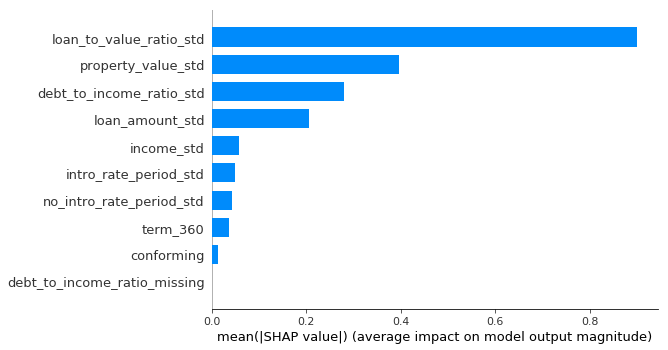

In [73]:
shap.summary_plot(shap_values_gbm, X, plot_type="bar")

In [74]:
# Save the model
model_path = h2o.save_model(model=best_gbm2, path="../models/GBM_BEST_GRID_v2_HMDA_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/GBM_BEST_GRID_v2_HMDA_1575927435.3138359/gbm_grid2_model_20


# Repeat Previous but with XGBoost

In [75]:
# Train and validate a random grid of XGBoost models
mxgb_grid = H2OGridSearch(model=H2OXGBoostEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    # learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='mxgb_grid2',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
mxgb_grid.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [76]:
# Get the grid results, sorted by validation AUC
mxgb_gridperf = mxgb_grid.get_grid(sort_by='auc', decreasing=True)

In [77]:
print(mxgb_gridperf)

          col_sample_rate learn_rate max_depth         sample_rate  \
0     0.30000000000000004        0.1         6  0.7000000000000001   
1      0.7000000000000001       0.09        10                 0.5   
2                     0.8       0.09        10  0.7000000000000001   
3     0.30000000000000004       0.08         6                 0.8   
4                     0.5        0.1         8  0.7000000000000001   
5      0.7000000000000001       0.08         9  0.6000000000000001   
6                     0.2       0.06         7                 0.8   
7                     0.2       0.09         6                 1.0   
8                     0.4       0.08         5                 0.8   
9      0.7000000000000001        0.1         3  0.7000000000000001   
10                    0.2        0.1         3                 0.8   
11                    0.4       0.07         5                 0.5   
12    0.30000000000000004       0.04        10                 0.9   
13                  

In [78]:
# Grab the top GBM model, chosen by validation AUC
best_mxgb = mxgb_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_mxgb_perf = best_mxgb.model_performance(test)

best_mxgb_perf.auc()

0.8076432704169134

# Shapley Importance

In [79]:
shap_values_mxgb, expected_value_mxgb = get_shapley(best_mxgb, train, X)

First 5 rows of contributions:



debt_to_income_ratio_missing.False,debt_to_income_ratio_missing.True,debt_to_income_ratio_missing.missing(NA),term_360,conforming,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,BiasTerm
-0.0279054,-0.017118,0,-4.30537e-05,-0.0158831,-0.191981,-0.39241,-0.104848,-0.155696,-0.205218,-0.0455992,0.00208951,0
-0.0428628,-0.0220296,0,-4.53843e-05,-0.0189243,-0.361263,-0.931136,-0.144612,-0.250869,-0.497511,-0.104077,-0.474516,0
-0.0110341,-0.00667279,0,7.18053e-05,0.00167255,0.00831683,-0.419404,-0.342049,-1.13808,-0.275266,-0.0721013,-0.163921,0
-0.013573,-0.0597384,0,-4.65753e-05,-0.10398,-0.455444,-2.39687,-0.434669,-0.376237,-0.714399,-0.0656964,-0.529831,0
-0.0278799,-0.0171317,0,-4.03123e-05,-0.0108963,-0.148726,-0.316384,-0.102255,-0.152272,-0.298293,-0.052357,-0.00910205,0


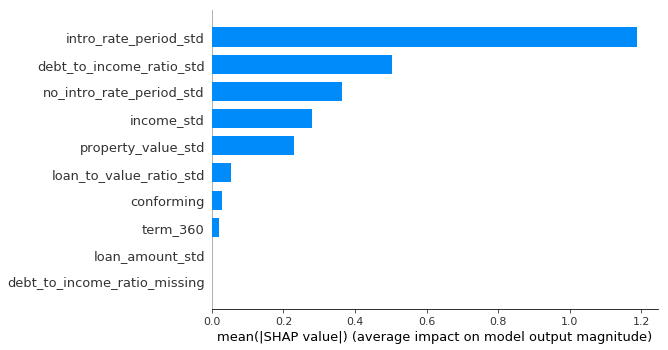

In [80]:
shap.summary_plot(shap_values_mxgb, X, plot_type="bar")

In [81]:
# Save the model
model_path = h2o.save_model(model=best_mxgb, path="../models/MXGB_BEST_GRID_v2_HMDA_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/MXGB_BEST_GRID_v2_HMDA_1575928031.3747108/mxgb_grid2_model_12


In [82]:
# Train and validate a random grid of XGBoost models
xgb_grid = H2OGridSearch(model=H2OXGBoostEstimator(distribution='bernoulli',
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    # learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='xgb_grid2',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
xgb_grid.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [83]:
# Get the grid results, sorted by validation AUC
xgb_gridperf = xgb_grid.get_grid(sort_by='auc', decreasing=True)

In [84]:
print(xgb_gridperf)

          col_sample_rate learn_rate max_depth         sample_rate  \
0                     0.9       0.08         6                 0.8   
1     0.30000000000000004        0.1         6  0.7000000000000001   
2                     0.9       0.06         6                 0.9   
3                     1.0       0.09         5                 0.5   
4      0.7000000000000001       0.04         8                 1.0   
5                     0.5        0.1         8  0.7000000000000001   
6     0.30000000000000004       0.08         6                 0.8   
7                     0.4       0.04         9                 0.5   
8      0.6000000000000001       0.04         7                 0.8   
9                     0.4       0.08         5                 0.8   
10    0.30000000000000004       0.04        10                 0.9   
11     0.7000000000000001       0.08         9  0.6000000000000001   
12                    0.9       0.04         7                 1.0   
13                  

In [85]:
# Grab the top GBM model, chosen by validation AUC
best_xgb = xgb_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_xgb_perf = best_xgb.model_performance(test)

best_xgb_perf.auc()

0.8295507199389082

# Shapley Importance

In [86]:
shap_values_xgb, expected_value_xgb = get_shapley(best_xgb, train, X)

First 5 rows of contributions:



debt_to_income_ratio_missing.False,debt_to_income_ratio_missing.True,debt_to_income_ratio_missing.missing(NA),term_360,conforming,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,BiasTerm
-0.0180966,-0.000509719,0,-0.00859936,-0.00181858,-0.379428,0.112091,-0.0277947,-0.0613861,-0.191586,-0.584845,-0.232942,0
-0.0180955,-0.00137637,0,-0.00324587,-0.00377074,-0.429348,-0.49926,-0.0304844,-0.0943847,-0.646625,-0.744191,-0.932606,0
-0.0113302,-0.000509159,0,-0.00608778,-0.00139556,-0.389222,-0.217226,-0.361329,-0.875725,-0.0697521,-0.456006,-0.553299,0
-0.0693226,-0.000627809,0,-0.0249719,-0.00395645,-0.983011,-1.55428,-0.218873,-0.17173,-1.15268,-0.404977,-0.781003,0
-0.0176021,-0.000509159,0,-0.00865142,-0.0013644,-0.415674,0.103324,-0.0284888,-0.0557718,-0.107839,-0.370852,-0.178833,0


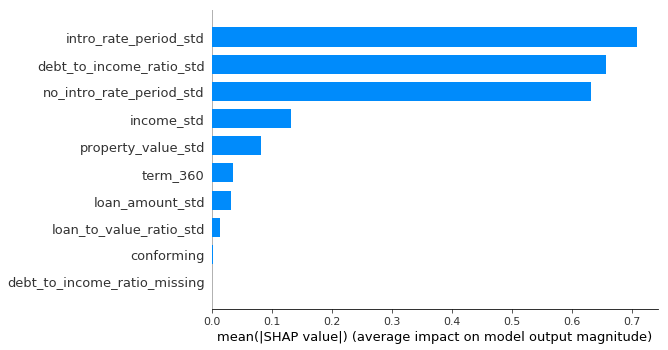

In [87]:
shap.summary_plot(shap_values_xgb, X, plot_type="bar")

In [88]:
# Save the model
model_path = h2o.save_model(model=best_xgb, path="../models/XGB_BEST_GRID_v2_HMDA_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/XGB_BEST_GRID_v2_HMDA_1575928848.548365/xgb_grid2_model_11
